# Implement and Analyze the Robustness of NMF Algorithms

---




##Introduction

In this notebook, we are going to implement and compare the robustness of two Non-Negative Matrix Factorization (NMF) algorithms: L2-norm NMF and L2,1-norm NMF.


In [ ]:
import os
import numpy as np
from PIL import Image
from numpy import sqrt
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1. Load Dataset

We will be using two sets of data, ORL dataset and extended YaleB dataset.

* The ORL dataset contains 400 images of 40 distinct subjects, and for some subjects, the images were taken at contrasting times with different lighting, facial expressions, and facial details. All images are cropped and resized to 92 x 112 pixels. To further reduce the computation complexity, we will resize all images to 30 x 37 pixels (3 times smaller).
* The extended YaleB dataset contains 2414 images of 38 subjects under 9 poses and 64 illumination conditions. All images are cropped and resized to 168 x 192 pixels. To further reduce the computation complexity, we will resize all images to 42 x 48 pixels (4 times smaller).

These dataset are loaded using `load_data` function, which take the parameters root and reduce. Root is used to store the dataset path, and reduce is a scale factor used for zooming out the images. In this case, we put `reduce = 3` as default.

The piece of code below mounts your google drive folder into this colab notebook, allowing you to access your data from the path "drive/MyDrive/". This can be ignored if you wish to run this notebook locally.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data(root, reduce = 3, norm = True):
    """
    Load the dataset to numpy array.

    If the argument `reduce` is not passed in, the default reduce factor is used.

    Parameters
    ----------
    root: str
      dataset file location.
    reduce: int, optional
      scale factor for zooming out images.

    Returns
    -------
    NumPy array
      array of images and its labels

    """

    images, labels = [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for filename in os.listdir(os.path.join(root, person)):

            # Remove background images (removing file ending with Ambient.pgm and not .pgm type)
            if filename.endswith('Ambient.pgm'):
                continue
            if not filename.endswith('.pgm'):
                continue

            # load image
            img = Image.open(os.path.join(root, person, filename))
            img = img.convert('L') # grey image

            # reduce computation complexity
            img = img.resize([s//reduce for s in img.size])

            # TODO: preprocessing.
            if norm == True:
              img = (img - np.min(img)) / (np.max(img) - np.min(img))

            # convert image to numpy array
            img = np.asarray(img).reshape((-1,1))

            # collect data and label
            images.append(img)
            labels.append(i)

    # concate all images and labels
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

To load the dataset, we are going to implement the `load_data` function above and passed in the file path for ORL and Extended YaleB dataset with their respective reduce factor stated before.

In [ ]:
# Load ORL dataset.
X_ORL, Y_ORL = load_data(root='drive/MyDrive/data/ORL', reduce = 3)
print('ORL dataset: X_ORL.shape = {}, Y_ORL.shape = {}'.format(X_ORL.shape, Y_ORL.shape))

# Load Extended YaleB dataset.
X_yale, Y_yale = load_data(root='drive/MyDrive/data/CroppedYaleB', reduce = 4)
print('Extended YaleB dataset: X_yale.shape = {}, Y_yale.shape = {}'.format(X_yale.shape, Y_yale.shape))

ORL dataset: X_ORL.shape = (1110, 400), Y_ORL.shape = (400,)
Extended YaleB dataset: X_yale.shape = (2016, 2414), Y_yale.shape = (2414,)


As we can see, the ORL dataset size is 1110 as we have reduced the images to 30 x 37 pixels, with 400 images in total. The same goes to the extended YaleB dataset, since we resized the image to 42 x 48 pixels we got the size 2016 with 2414 images in total.

From the shape, we know that the image itself is stored in a 1D array. To make it easier in the next part, we are going to make a function `convertarray` intented to conver our 1D array into a 2D matrix according to the width and height of the image.

In [ ]:
def convertarray(array, w, h):
    """
    Function to convert a 1D array image into a 2D matrix

    Parameters
    ----------
    array: NumPy array
      the image array we want to convert
    width: int
      the image width
    height: int
      the image height

    Returns
    -------
    NumPy array
      2D matrix of the image

    """
    return np.asarray(array).reshape(h, w)

To see the original image we are going to use, we can display it after converting it to a 2D matrix. We will put 6 examples for each dataset.

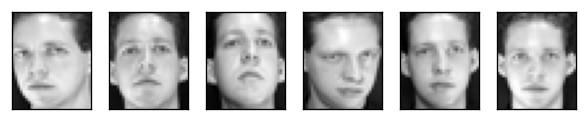

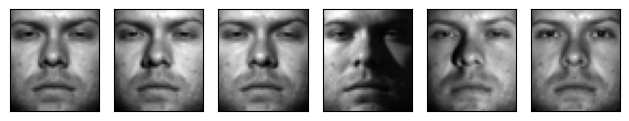

In [ ]:
plt.figure(figsize=(5,5), dpi=120)

img_num = 6
#Displaying 6 original ORL images
for i in range(img_num):
    plt.subplot(1, img_num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img = convertarray(X_ORL[:, i], h = 37, w = 30)
    plt.imshow(img, cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

#Displaying 6 original Yale images
for i in range(img_num):
    plt.subplot(1, img_num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img = convertarray(X_yale[:, i], h = 48, w = 42)
    plt.imshow(img, cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

## 2. Implementing Noises

In this section, we are going to implement three types of different noises: gaussian, salt and pepper, and block occlusion.

### 2.1. Gaussian Noise

Gaussian noise is statistical noise that has a probability density function equal to that of the normal (Gaussian) distribution. Images contaminated with gaussian noise have pixel value equal to its original value plus a random Gaussian noise value.

The following code takes an image dataset and outputs a noisy version of said dataset. The parameters **mu** and **sigma** are used, but we will mainly use **sigma** to indicate the level of noisiness, with higher **sigma** equating higher levels of disturbance in the image.

In [ ]:
def generate_gaussian_noise(X, mu = 0, sigma = 1):
    """
    Function to implement gaussian noise to images

    If the argument `mu` and `sigma` are not passed in, the default values are used.

    Parameters
    ----------
    X: NumPy array
      array of image we want to alter.
    mu: int, optional
      mu / mean determines the center of Gaussian distribution. Mu of 0 means the added noise does not increase or decrease the pixel values in the image.
    sigma: int, optional
      sigma / standard deviation determines the intensity of the noise. Lower sigma results in less noise (closer to original image) and vice versa.

    Returns
    -------
    NumPy array
      array of images altered with noise

    """
    noise = np.random.normal(mu, sigma, X.shape).reshape(X.shape)
    output = np.copy(X) + noise

    return output

### 2.2. Salt and Pepper Noise

Salt and pepper noise: also called impulsive noise, causes white or black pixels to appear in place of color values in the image. Its appearance not dissimilar to salt and pepper granules hence the name.

The following code takes an image dataset and outputs a noisy version of said dataset. The parameters **prob** and **ratio** are used, with **prob** equating the percentage amount of the image to be covered, and **ratio** determining the ratio of salt (white pixel) against the pepper (black pixel) contaminating the data. Higher **ratio** will cause higher salt noise to appear over the pepper noise.

In [ ]:
def generate_sp_noise(X, prob = 0.25, ratio = 0.5):
    """
    Function to implement salt and pepper noise to images

    If the argument `prob` and `ratio` are not passed in, the default values are used.

    Parameters
    ----------
    X: NumPy array
      array of image we want to alter.
    prob: float, optional
      probability of the noise added. It determines the density of noise.
    ratio: float, optional
      ratio represents the ratio of salt (white pixels) to the total noise pixels.

    Returns
    -------
    NumPy array
      array of images altered with noise

    """
    output = np.copy(X)

    salt = output[:,0].size * prob * ratio
    pepper = output[:,0].size * prob * (1-ratio)

    for image in output.T:
      for i in range(int(salt)):
          x = np.random.randint(0,image.size)
          image[x] = 1

      for i in range(int(pepper)):
          x = np.random.randint(0,image.size)
          image[x] = 0

    return output


### 2.3. Block occlusion Noise

Block occlusion noise is a type of noise where a significant percentage of the image is covered by a block, typically white or black and rectangular in shape.

The following code takes an image dataset X and outputs a noisy version of said dataset. There are several parameters used in this function.

`img_w` and `img_h` indicates the actual shape of the image. Recall that the shape of X_ORL is (1100x400), but the actual shape of each images are said to be (30x37). In this function, the images are reshaped back into their actual image shape in order to apply the block noise. After the block noise has been applied, the image is then transformed back again into a 1D array.

`size` indicates the size of the block noise in pixels.

In [ ]:
def generate_block_noise(X, img_h, img_w, size = 5):
    """
    Function to implement block occlusion noise to images

    If the argument `size` is not passed in, the default value is used.

    Parameters
    ----------
    X: NumPy array
      array of image we want to alter.
    img_h: int
      the height of the image.
    img_w: int
      the width of the image.
    size: int, optional
      the size of noise we want to add.

    Returns
    -------
    NumPy array
      array of images altered with noise

    """
    output = np.copy(X)
    index = 0

    # Generate random coordinates for the block occlusion for every image
    for image in output.T:
      #generate random coordinates for the blocks
      x = np.random.randint(0,img_h-size)
      y = np.random.randint(0,img_w-size)

      #reshape image into 2d array so we can apply the box
      image = convertarray(image, h = img_h, w = img_w)
      image[x:x+size, y:y+size] = 1

      #reshape image to the original X[:,i] shape
      image = np.asarray(image).reshape(X.shape[0])
      output[:, index] = image
      index = index + 1

    return output

We will provide the example of each noise on the first image of ORL dataset to further understand the differences.

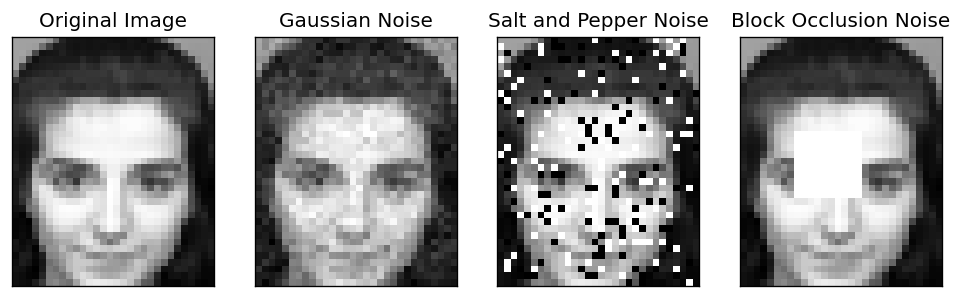

In [ ]:
plt.figure(figsize=(10,10), dpi=120)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if i == 0:
      X_noisy = X_ORL
      title = "Original Image"
    elif i == 1:
      X_noisy = generate_gaussian_noise(X_ORL, mu = 0, sigma = 0.05)
      title = "Gaussian Noise"
    elif i == 2:
      X_noisy = generate_sp_noise(X_ORL, prob = 0.2, ratio = 0.5)
      title = "Salt and Pepper Noise"
    else:
      X_noisy = generate_block_noise(X_ORL, img_h = 37, img_w = 30, size = 10)
      title = "Block Occlusion Noise"

    noisy_img = convertarray(X_noisy[:, 10], h=37, w=30)

    plt.title(f'{title}', fontsize = 12)
    plt.imshow(noisy_img, cmap=plt.cm.gray)

plt.show()

## 3. Evaluation Metrics

In this section, we are going to define three different evaluation metrics to test our implemented NMF: Root means square error (RMSE), average accuracy, and normalized mutual information (NMI). Both average accuracy and NMI require us to cluster the label, therefore we are going to make a function `assign_cluster_label` to make it easier in the following calculation. In this function, we are going to use python library sklearn KMeans.

In [ ]:
def assign_cluster_label(X, Y):
    """
    Function to cluster the data

    Parameters
    ----------
    X: NumPy array
      array of contaminated image.
    Y: NumPy array
      array of the true Y of the image.

    Returns
    -------
    NumPy array
      array of predicted Y values.

    """
    kmeans = KMeans(n_clusters=len(set(Y))).fit(X)
    Y_pred = np.zeros(Y.shape)
    for i in set(kmeans.labels_):
        ind = kmeans.labels_ == i
        Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
    return Y_pred

### 3.1. Root Means Square Error (RMSE)

we measure how far from the regression line data points are. Let $X$ denote the contaminated dataset and $\hat X$ denote the clean dataset with N num of rows x num of columns. $U$ and $V$ are the factorization results on $\hat X$. RMSE can be defined as follows:

$RMSE= \sqrt{\frac{1}{N} ||\hat X - UV||^2_F}$

In this notebook, we are using the python library sklearn to quickly implement RMSE evaluation.

In [ ]:
def rmse(X, U, V):
    """
    Function to test the error rate using RMSE with the help of sklearn

    Parameters
    ----------
    X: NumPy array
      array of original image.
    U: NumPy array
      factorization results of X.
    V: NumPy array
      factorization results of X.

    Returns
    -------
    float
      the result of RMSE.

    """
    return sqrt(mean_squared_error(X, U.dot(V)))

### 3.2. Average Accuracy
we perform clustering using K-means with num clusters equal to num classes. The average accuracy can be defined as follows:

$Acc(Y, Y_{pred}) = \frac{1}{n}\sum_{i=1}^n 1\{Y_{pred(i)} == Y(i)\}$

In [ ]:
def acc(Y_true, Y_pred):
    """
    Function to test the error rate using average accuracy with the help of sklearn

    Parameters
    ----------
    Y_true: NumPy array
      array of original Y.
    Y_pred: NumPy array
      array of predicted Y obtained by clustering.

    Returns
    -------
    float
      the result of average accuracy.

    """
    return accuracy_score(Y_true, Y_pred)

### 3.3. Normalized Mutual Information (NMI)
used to evaluate the clustering quality from information point. This can be defined as follows:

$NMI(Y, Y_{pred}) = \frac{2*I(Y, Y_{pred})}{H(Y) + H(Y_{pred})}$

In [ ]:
def nmi(Y_true, Y_pred):
    """
    Function to test the error rate using NMI with the help of sklearn

    Parameters
    ----------
    Y_true: NumPy array
      true image label.
    Y_pred: NumPy array
      array of predicted Y obtained by clustering.

    Returns
    -------
    float
      the result of NMI.

    """
    return normalized_mutual_info_score(Y_true, Y_pred)

All the evaluation metrics then inputted together in one `evaluation` function to make it easier to call.

In [ ]:
def evaluation(X, Y_true, U, V):
  """
  Method to do all the evaluation for NMF

  Parameters
  ----------
  X: NumPy array
    Original image array
  Y_true: NumPy array
    true image label
  U: NumPy array
    Factorization result of X
  V: NumPy array
    Factorization result of X

  Returns
  -------
  float
    Test results for RMSE, Average Accuracy, and NMI

  """
  Y_pred = assign_cluster_label(V.T, Y_true)
  rmse_result = rmse(X, U, V)
  acc_result = acc(Y_true, Y_pred)
  nmi_result = nmi(Y_true, Y_pred)
  return rmse_result, acc_result, nmi_result

## 4. Non-negative Matrix Factorization

In this section, we are going to implement the NMF algorithm into our dataset. In our algorithm, we will randomize the starting matrix for our iteration. To make it easier for the following calculation, we are going to make the function `initialize_matrice` to initialize our matrix.

In [ ]:
def initialize_matrice(size, components):
  """
  Matrice initialization U and V for factorization results of X
  If X is the size of m x n, then U will be the size of m x r and V the size of r x n
  In this case, size holds the number of (m, n) and components is equal to r

  Parameters
  ----------
  size: array
    array indicating the dataset size
  components: int
    number of components

  Returns
  -------
  NumPy array
    Randomized array of U and V

  """
  U = np.random.uniform(1,2,(size[0], components))
  V = np.random.uniform(1,2,(components, size[1]))
  return U, V

### 4.1. L2-Norm NMF

To build our model of L2-norm, we use the class l2norm. The initialization includes steps (number of iteration), eps (loss criterion), and n_components (number of basis). Inside this class, we have function `fit` to fit all the data we have including original data and contaminated data, function `calculate` to do the iteration, and `reconstruct_data` to display the reconstructed contaminated image.

In [ ]:
class l2norm():
  """
  Class constructor for L2-norm NMF

  """
  def __init__(self, steps = 100, eps = 1e-10, n_components = 20):
    """
    L2-norm NMF initialization

    Parameters
    ----------
    steps: int, optional
      number of maximum iteration.
    eps: float, optional
      loss criterion.
    n_components: int, optional
      number of components to learn.

    """
    self.steps = steps
    self.eps = eps
    self.n_components = n_components

  def fit(self, X, contaminated_X, Y):
    """
    Method to fit the original data and contaminated data into the model

    Parameters
    ----------
    X: NumPy array
      original image data.
    contaminated_X: NumPy array
      image contaminated with noise.
    Y: NumPy array
      true image label.

    """
    self.X = X
    self.contaminated_X = contaminated_X
    self.Y = Y

  def calculate(self):
    """
    Method to calculate the updated variables X ~ UV

    Returns
    -------
    NumPy array
      array of updated U and V.

    """

    U, V = initialize_matrice(self.contaminated_X.shape, self.n_components)

    for step in range(self.steps):
        U_update = U * (self.contaminated_X.dot(V.T)) / (U.dot(V).dot(V.T))
        V_update = V * ((U_update.T).dot(self.contaminated_X)) / ((U_update.T).dot(U_update).dot(V))

        e_U = np.sqrt(np.sum((U_update - U)**2, axis=(0,1)))/U.size
        e_V = np.sqrt(np.sum((V_update - V)**2, axis=(0,1)))/V.size

        if e_U < self.eps and e_V < self.eps:
            print("step is:", step)
            break


        U = U_update
        V = V_update
    return U, V


  def reconstruct_data(self, U, V):
    """
    Method to reconstruct the data using the factorized X

    Parameters
    ----------
    U: NumPy array
      Factorized results of X
    V: NumPy array
      Factorized results of X

    Returns
    -------
    NumPy array
      The product of U and V

    """
    return U.dot(V)

We will test the implementation of our L2-norm NMF using ORL dataset with Gaussian noise.

In [ ]:
nmfmodel = l2norm(n_components = 40)
contaminated_X = generate_gaussian_noise(X_ORL, mu = 0, sigma = 0.05)
nmfmodel.fit(X = X_ORL, contaminated_X = contaminated_X, Y = Y_ORL)
U, V = nmfmodel.calculate()
X_hat = nmfmodel.reconstruct_data(U, V)

rmse, acc, nmi = evaluation(X = X_ORL, Y_true = Y_ORL, U = U, V = V)

print(f"RMSE: {rmse}")
print(f"Accuracy: {acc}")
print(f"NMI: {nmi}")

RMSE: 0.10459345601591677
Accuracy: 0.6525
NMI: 0.8118832510461446


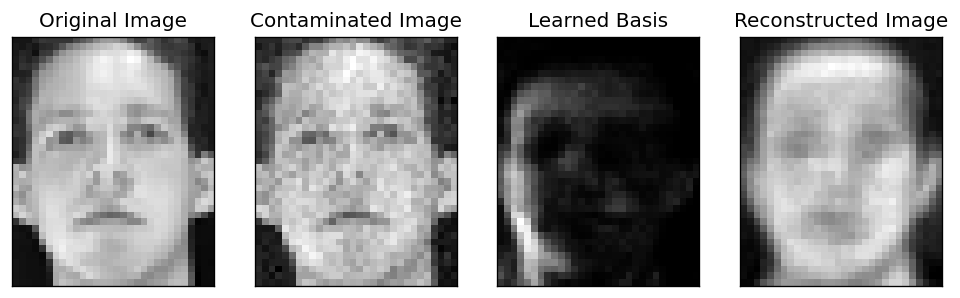

In [ ]:
plt.figure(figsize=(10,10), dpi=120)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if i == 0:
      X = X_ORL
      title = "Original Image"
    elif i == 1:
      X = generate_gaussian_noise(X_ORL, mu = 0, sigma = 0.05)
      title = "Contaminated Image"
    elif i == 2:
      X = U
      title = "Learned Basis"
    else:
      X = X_hat
      title = "Reconstructed Image"

    img = convertarray(X[:, 1], h=37, w=30)

    plt.title(f'{title}', fontsize = 12)
    plt.imshow(img, cmap=plt.cm.gray)

plt.show()

### 4.2. L21-Norm NMF

To build our model of L21-norm, we use the class l21norm. The initialization includes steps (number of iteration), eps (loss criterion), and n_components (number of basis). Inside this class, we have function `fit` to fit all the data we have including original data and contaminated data, function `calculate` to do the iteration, and `reconstruct_data` to display the reconstructed contaminated image.

In [ ]:
class l21norm():
  """
  Class constructor for L21-norm NMF

  """
  def __init__(self, steps = 100, eps = 1e-10, n_components = 20):
    """
    L21-norm NMF initialization

    Parameters
    ----------
    steps: int, optional
      number of maximum iteration.
    eps: float, optional
      loss criterion.
    n_components: int, optional
      number of components to learn.

    """
    self.steps = steps
    self.eps = eps
    self.n_components = n_components

  def fit(self, X, contaminated_X, Y):
    """
    Method to fit the original data and contaminated data into the model

    Parameters
    ----------
    X: NumPy array
      original image data.
    contaminated_X: NumPy array
      image contaminated with noise.
    Y: NumPy array
      true image label.

    """
    self.X = X
    self.contaminated_X = contaminated_X
    self.Y = Y

  def calculate(self):
    """
    Method to calculate the updated variables X ~ UV

    Returns
    -------
    NumPy array
      array of updated U and V.

    """

    U, V = initialize_matrice(self.X.shape, self.n_components)
    D = np.zeros((self.X.shape[1], self.X.shape[1]))

    for step in range(self.steps):
      D = np.diag(1 / np.sqrt(np.sum(np.square(self.contaminated_X - U.dot(V)), axis=0)))

      U_new = U * ( self.contaminated_X.dot(D).dot(V.T) / U.dot(V).dot(D).dot(V.T) )
      V_new = V * ( (U_new.T).dot(self.contaminated_X).dot(D) / (U_new.T).dot(U_new).dot(V).dot(D) )

      U_hat = np.sqrt(np.sum((U_new - U)**2, axis=(0,1)))/U.size
      V_hat = np.sqrt(np.sum((V_new - V)**2, axis=(0,1)))/V.size

      if U_hat < self.eps and V_hat < self.eps:
        print("step is:",step)
        break

      U = U_new
      V = V_new
    return U, V


  def reconstruct_data(self, U, V):
    """
    Method to reconstruct the data using the factorized X

    Parameters
    ----------
    U: NumPy array
      Factorized results of X
    V: NumPy array
      Factorized results of X

    Returns
    -------
    NumPy array
      The product of U and V

    """
    return U.dot(V)

Using the same data we tested on L2-Norm NMF, we are going to test it on L2,1-Norm NMF.

In [ ]:
nmfmodel = l21norm(n_components = 40)
contaminated_X = generate_gaussian_noise(X_ORL, mu = 0, sigma = 0.2)
nmfmodel.fit(X = X_ORL, contaminated_X = contaminated_X, Y = Y_ORL)
U, V = nmfmodel.calculate()
X_hat = nmfmodel.reconstruct_data(U, V)

def rmse(X, U, V):
    return sqrt(mean_squared_error(X, U.dot(V)))

def acc(Y_true, Y_pred):
    return accuracy_score(Y_true, Y_pred)

def nmi(Y_true, Y_pred):
    return normalized_mutual_info_score(Y_true, Y_pred)

rmse, acc, nmi = evaluation(X = X_ORL, Y_true = Y_ORL, U = U, V = V)

print(f"RMSE: {rmse}")
print(f"Accuracy: {acc}")
print(f"NMI: {nmi}")

RMSE: 0.11572398636567417
Accuracy: 0.71
NMI: 0.8230656628981701


We will display one of the example of the original image, contaminated image, basis learned, and reconstructed image side by side as a reference. We are using the ORL dataset.

In [ ]:
plt.figure(figsize=(10,10), dpi=120)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if i == 0:
      X = X_ORL
      title = "Original Image"
    elif i == 1:
      X = contaminated_X
      title = "Contaminated Image"
    elif i == 2:
      X = U
      title = "Learned Basis"
    else:
      X = X_hat
      title = "Reconstructed Image"

    img = convertarray(X[:, 1], h=37, w=30)

    plt.title(f'{title}', fontsize = 12)
    plt.imshow(img, cmap=plt.cm.gray)

plt.show()

## 5. Experiments

In this section, we are going to use the algorithm we implemented on all the dataset we have. We will run the same experiment 5 times and display the mean and standard deviation of the results.

In [ ]:
def rmse(X, U, V):
    """
    Function to test the error rate using RMSE with the help of sklearn

    Parameters
    ----------
    X: NumPy array
      array of original image.
    U: NumPy array
      factorization results of X.
    V: NumPy array
      factorization results of X.

    Returns
    -------
    float
      the result of RMSE.

    """
    return sqrt(mean_squared_error(X, U.dot(V)))

def acc(Y_true, Y_pred):
    """
    Function to test the error rate using average accuracy with the help of sklearn

    Parameters
    ----------
    Y_true: NumPy array
      array of original Y.
    Y_pred: NumPy array
      array of predicted Y obtained by clustering.

    Returns
    -------
    float
      the result of average accuracy.

    """
    return accuracy_score(Y_true, Y_pred)

def nmi(Y_true, Y_pred):
    """
    Function to test the error rate using NMI with the help of sklearn

    Parameters
    ----------
    Y_true: NumPy array
      true image label.
    Y_pred: NumPy array
      array of predicted Y obtained by clustering.

    Returns
    -------
    float
      the result of NMI.

    """
    return normalized_mutual_info_score(Y_true, Y_pred)

def evaluation(X, Y_true, U, V):
  """
  Method to do all the evaluation for NMF

  Parameters
  ----------
  X: NumPy array
    Original image array
  Y_true: NumPy array
    true image label
  U: NumPy array
    Factorization result of X
  V: NumPy array
    Factorization result of X

  Returns
  -------
  float
    Test results for RMSE, Average Accuracy, and NMI

  """
  Y_pred = assign_cluster_label(V.T, Y_true)
  rmse_result = rmse(X, U, V)
  acc_result = acc(Y_true, Y_pred)
  nmi_result = nmi(Y_true, Y_pred)
  return rmse_result, acc_result, nmi_result


In [ ]:
def experiment(method, X, Y, noise, n_times = 5, **params):
  """
  Method to run all the algorithm according to the chosen method

  Parameters
  ----------
  method: str (l2, l21)
    chosen between L2-norm and L2,1 norm NMF
  X: NumPy array
    Original image data
  Y: NumPy array
    Original image labels
  noise: str (gaussian, sp, block)
    noise type
  n_times: int
    number of experiments to do

  Returns
  -------
  Array
    array of the average result and standard deviation result for every evaluation metrics

  """

  rmse_results1 = []
  acc_results1 = []
  nmi_results1 = []
  rmse_results2 = []
  acc_results2 = []
  nmi_results2 = []
  rmse_results3 = []
  acc_results3 = []
  nmi_results3 = []
  mean_results = []
  stdev_results = []

  #generate the noise with gaussian, salt and pepper, and block occlusion
  print("<-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.->")
  if noise == 'gaussian':
    gaussian_sigma = params.get("gaussian_sigma")
    print("Noise Type: Gaussian")
    print(f"sigma used in this experiment: {gaussian_sigma}")
    contaminated_X = []
    for sigma in gaussian_sigma:
      contaminated_X.append(generate_gaussian_noise(X = X, mu = 0, sigma = sigma))
  elif noise == 'sp':
    sp_p = params.get("sp_p")
    print("Noise Type: Salt & Pepper")
    print(f"noise probability used in this experiment: {sp_p}")
    contaminated_X = []
    for p in sp_p:
      contaminated_X.append(generate_sp_noise(X = X, prob = p, ratio = 0.5))
  elif noise == 'block':
    print("Noise Type: Block Occlusion")
    block_size = params.get("block_size")
    print(f"block size used in this experiment: {block_size}")
    contaminated_X = []
    if(X.shape[0] == 1110):
      for size in block_size:
        contaminated_X.append(generate_block_noise(X = X, img_w = 30, img_h = 37, size = size))
    else:
      for size in block_size:
        contaminated_X.append(generate_block_noise(X = X, img_w = 42, img_h = 48, size = size))
  else:
    print('invalid noise type.')
    pass

  if method == 'l2':
    print("Method: L2-Norm NMF")
    print("-------------------")
    for n in range(n_times):
      print(f"\nExperiment Number: {n+1}")
      for id, con_X in enumerate(contaminated_X):
        print(f"number {id+1} of the parameter")
        method = l2norm(n_components = 10)
        method.fit(X = X, contaminated_X = con_X, Y = Y)
        U, V = method.calculate()
        X_hat = method.reconstruct_data(U, V)
        rmse, acc, nmi = evaluation(X = X, Y_true = Y, U = U, V = V)
        if id+1 == 1:
          rmse_results1.append(rmse)
          acc_results1.append(acc)
          nmi_results1.append(nmi)
        elif id+1 == 2:
          rmse_results2.append(rmse)
          acc_results2.append(acc)
          nmi_results2.append(nmi)
        else:
          rmse_results3.append(rmse)
          acc_results3.append(acc)
          nmi_results3.append(nmi)
        print(f"RMSE: {rmse}, Accuracy: {acc}, NMI: {nmi}")

  elif method == 'l21':
    print("Method: L21-Norm NMF")
    print("--------------------")
    for n in range(n_times):
      print(f"\nExperiment Number: {n+1}")
      for id, con_X in enumerate(contaminated_X):
        print(f"number {id+1} of the parameter")
        method = l21norm(n_components = 10)
        method.fit(X = X, contaminated_X = con_X, Y = Y)
        U, V = method.calculate()
        X_hat = method.reconstruct_data(U, V)
        rmse, acc, nmi = evaluation(X = X, Y_true = Y, U = U, V = V)
        if id+1 == 1:
          rmse_results1.append(rmse)
          acc_results1.append(acc)
          nmi_results1.append(nmi)
        elif id+1 == 2:
          rmse_results2.append(rmse)
          acc_results2.append(acc)
          nmi_results2.append(nmi)
        else:
          rmse_results3.append(rmse)
          acc_results3.append(acc)
          nmi_results3.append(nmi)
        print(f"RMSE: {rmse}, Accuracy: {acc}, NMI: {nmi}")

  else:
    print("Algorithm not found.")

  mean_results.append(np.mean(rmse_results1))
  mean_results.append(np.mean(acc_results1))
  mean_results.append(np.mean(nmi_results1))
  stdev_results.append(np.std(rmse_results1))
  stdev_results.append(np.std(acc_results1))
  stdev_results.append(np.std(nmi_results1))
  mean_results.append(np.mean(rmse_results2))
  mean_results.append(np.mean(acc_results2))
  mean_results.append(np.mean(nmi_results2))
  stdev_results.append(np.std(rmse_results2))
  stdev_results.append(np.std(acc_results2))
  stdev_results.append(np.std(nmi_results2))
  mean_results.append(np.mean(rmse_results3))
  mean_results.append(np.mean(acc_results3))
  mean_results.append(np.mean(nmi_results3))
  stdev_results.append(np.std(rmse_results3))
  stdev_results.append(np.std(acc_results3))
  stdev_results.append(np.std(nmi_results3))

  print("\nOverall Average test results")
  print("==============================")
  print("FIRST PARAMETER")
  print(f"RMSE = {mean_results[0]}\nAcc = {mean_results[1]}\nNMI = {mean_results[2]}")
  print("SECOND PARAMETER")
  print(f"RMSE = {mean_results[3]}\nAcc = {mean_results[4]}\nNMI = {mean_results[5]}")
  print("THIRD PARAMETER")
  print(f"RMSE = {mean_results[6]}\nAcc = {mean_results[7]}\nNMI = {mean_results[8]}")
  print("\nOverall Standard Deviation test results")
  print("=========================================")
  print("FIRST PARAMETER")
  print(f"RMSE = {stdev_results[0]}\nAcc = {stdev_results[1]}\nNMI = {stdev_results[2]}")
  print("SECOND PARAMETER")
  print(f"RMSE = {stdev_results[3]}\nAcc = {stdev_results[4]}\nNMI = {stdev_results[5]}")
  print("THIRD PARAMETER")
  print(f"RMSE = {stdev_results[6]}\nAcc = {stdev_results[7]}\nNMI = {stdev_results[8]}")
  print("<-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.->\n")

  return mean_results, stdev_results

### 5.1. ORL Dataset

In [ ]:
#Experiments configuration
methods = ["l2", "l21"]
noises = ["gaussian", "sp", "block"]
params = {"gaussian_sigma":[0.2, 1, 5], "sp_p":[0.25, 0.5, 0.75], "block_size": [5, 10, 20]}

#Store data
all_mean_rmse_l2 = []
all_mean_acc_l2 = []
all_mean_nmi_l2 = []
all_stdev_rmse_l2 = []
all_stdev_acc_l2 = []
all_stdev_nmi_l2 = []
all_mean_rmse_l21 = []
all_mean_acc_l21 = []
all_mean_nmi_l21 = []
all_stdev_rmse_l21 = []
all_stdev_acc_l21 = []
all_stdev_nmi_l21 = []

for method in methods:
  for noise in  noises:
    mean_results, stdev_results = experiment(method = method, X = X_ORL, Y = Y_ORL, noise = noise, **params)
    if method == 'l2':
      for index, value in enumerate(mean_results):
        if index % 3 == 0:
          all_mean_rmse_l2.append(mean_results[index])
          all_stdev_rmse_l2.append(stdev_results[index])
        elif index % 3 == 1:
          all_mean_acc_l2.append(mean_results[index])
          all_stdev_acc_l2.append(stdev_results[index])
        else:
          all_mean_nmi_l2.append(mean_results[index])
          all_stdev_nmi_l2.append(stdev_results[index])
    else:
      for index, value in enumerate(mean_results):
        if index % 3 == 0:
          all_mean_rmse_l21.append(mean_results[index])
          all_stdev_rmse_l21.append(stdev_results[index])
        elif index % 3 == 1:
          all_mean_acc_l21.append(mean_results[index])
          all_stdev_acc_l21.append(stdev_results[index])
        else:
          all_mean_nmi_l21.append(mean_results[index])
          all_stdev_nmi_l21.append(stdev_results[index])

<-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.->
Noise Type: Gaussian
sigma used in this experiment: [0.2, 1, 5]
Method: L2-Norm NMF
-------------------

Experiment Number: 1
number 1 of the parameter
RMSE: 0.13366458527032687, Accuracy: 0.595, NMI: 0.7747240288315502
number 2 of the parameter
RMSE: 0.24306024057424053, Accuracy: 0.2225, NMI: 0.41302401278523976
number 3 of the parameter
RMSE: 5.196934571526615, Accuracy: 0.15, NMI: 0.28188115661808066

Experiment Number: 2
number 1 of the parameter
RMSE: 0.13523641752048754, Accuracy: 0.5975, NMI: 0.7663662975833382
number 2 of the parameter
RMSE: 0.24316089608235641, Accuracy: 0.21, NMI: 0.36905915264370176
number 3 of the parameter
RMSE: 439.44034982179693, Accuracy: 0.1375, NMI: 0.22721829016228312

Experiment Number: 3
number 1 of the parameter
RMSE: 0.1322957152125777, Accuracy: 0.625, NMI: 0.7784663028420947
number 2 of the parameter
RMSE: 0.24479636757575512, Accuracy: 0.

#### Overall Average Result

Plotting the average results for each type of noise to compare two algorithms

In [ ]:
gaussian_rmse_l2 = []
sp_rmse_l2 = []
block_rmse_l2 = []
gaussian_acc_l2 = []
sp_acc_l2 = []
block_acc_l2 = []
gaussian_nmi_l2 = []
sp_nmi_l2 = []
block_nmi_l2 = []

gaussian_rmse_l21 = []
sp_rmse_l21 = []
block_rmse_l21 = []
gaussian_acc_l21 = []
sp_acc_l21 = []
block_acc_l21 = []
gaussian_nmi_l21 = []
sp_nmi_l21 = []
block_nmi_l21 = []

for j, value in enumerate(all_mean_rmse_l2):
  if j < 3:
    gaussian_rmse_l2.append(value)
  elif j < 6:
    sp_rmse_l2.append(value)
  else:
    block_rmse_l2.append(value)

for j, value in enumerate(all_mean_acc_l2):
  if j < 3:
    gaussian_acc_l2.append(value)
  elif j < 6:
    sp_acc_l2.append(value)
  else:
    block_acc_l2.append(value)

for j, value in enumerate(all_mean_nmi_l2):
  if j < 3:
    gaussian_nmi_l2.append(value)
  elif j < 6:
    sp_nmi_l2.append(value)
  else:
    block_nmi_l2.append(value)

for j, value in enumerate(all_mean_rmse_l21):
  if j < 3:
    gaussian_rmse_l21.append(value)
  elif j < 6:
    sp_rmse_l21.append(value)
  else:
    block_rmse_l21.append(value)

for j, value in enumerate(all_mean_acc_l21):
  if j < 3:
    gaussian_acc_l21.append(value)
  elif j < 6:
    sp_acc_l21.append(value)
  else:
    block_acc_l21.append(value)

for j, value in enumerate(all_mean_nmi_l21):
  if j < 3:
    gaussian_nmi_l21.append(value)
  elif j < 6:
    sp_nmi_l21.append(value)
  else:
    block_nmi_l21.append(value)

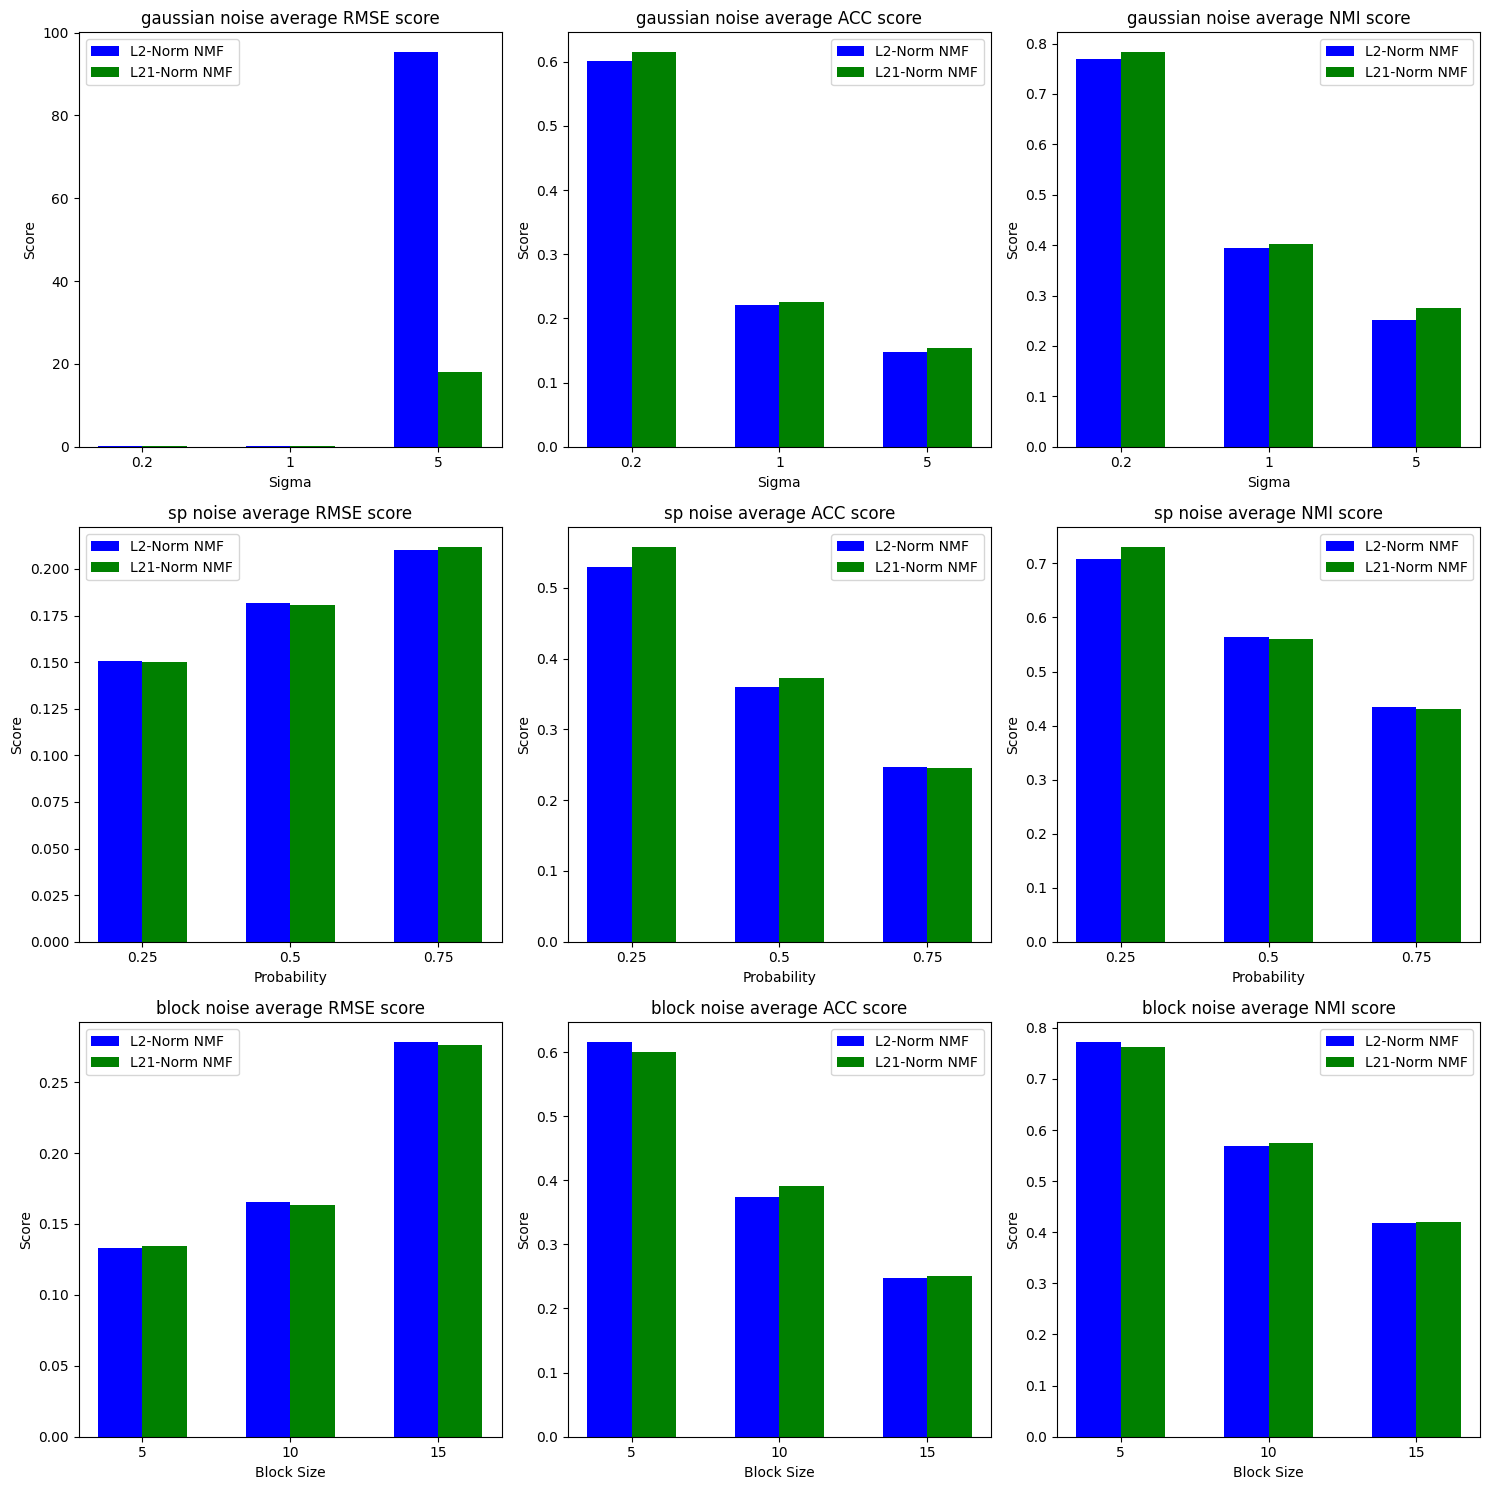

In [ ]:
n_groups = len(noises)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
bar_width = 0.3
index = np.arange(n_groups)
for i, noise_type in enumerate(noises):
  for j, metrics in enumerate(["RMSE","ACC", "NMI"]):
    ax = axs[i][j]
    ax.set_xticks(index + bar_width/2)
    if noise_type == "gaussian":
      ax.set_xticklabels(('0.2', '1', '5'))
      ax.set_xlabel('Sigma')
      if metrics == "RMSE":
        rects1 = ax.bar(index, gaussian_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, gaussian_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, gaussian_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    elif noise_type == "sp":
      ax.set_xticklabels(('0.25', '0.5', '0.75'))
      ax.set_xlabel('Probability')
      if metrics == "RMSE":
        rects1 = ax.bar(index, sp_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, sp_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, sp_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    else:
      ax.set_xticklabels(('5', '10', '15'))
      ax.set_xlabel('Block Size')
      if metrics == "RMSE":
        rects1 = ax.bar(index, block_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, block_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, block_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_nmi_l21, bar_width, color='g', label='L21-Norm NMF')
    ax.set_ylabel('Score')
    ax.set_title(f'{noise_type} noise average {metrics} score')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

#### Overall Standard Deviation Result

Plotting the standard deviation results for each type of noise to compare two algorithms

In [ ]:
gaussian_rmse_l2 = []
sp_rmse_l2 = []
block_rmse_l2 = []
gaussian_acc_l2 = []
sp_acc_l2 = []
block_acc_l2 = []
gaussian_nmi_l2 = []
sp_nmi_l2 = []
block_nmi_l2 = []

gaussian_rmse_l21 = []
sp_rmse_l21 = []
block_rmse_l21 = []
gaussian_acc_l21 = []
sp_acc_l21 = []
block_acc_l21 = []
gaussian_nmi_l21 = []
sp_nmi_l21 = []
block_nmi_l21 = []

for j, value in enumerate(all_stdev_rmse_l2):
  if j < 3:
    gaussian_rmse_l2.append(value)
  elif j < 6:
    sp_rmse_l2.append(value)
  else:
    block_rmse_l2.append(value)

for j, value in enumerate(all_stdev_acc_l2):
  if j < 3:
    gaussian_acc_l2.append(value)
  elif j < 6:
    sp_acc_l2.append(value)
  else:
    block_acc_l2.append(value)

for j, value in enumerate(all_stdev_nmi_l2):
  if j < 3:
    gaussian_nmi_l2.append(value)
  elif j < 6:
    sp_nmi_l2.append(value)
  else:
    block_nmi_l2.append(value)

for j, value in enumerate(all_stdev_rmse_l21):
  if j < 3:
    gaussian_rmse_l21.append(value)
  elif j < 6:
    sp_rmse_l21.append(value)
  else:
    block_rmse_l21.append(value)

for j, value in enumerate(all_stdev_acc_l21):
  if j < 3:
    gaussian_acc_l21.append(value)
  elif j < 6:
    sp_acc_l21.append(value)
  else:
    block_acc_l21.append(value)

for j, value in enumerate(all_stdev_nmi_l21):
  if j < 3:
    gaussian_nmi_l21.append(value)
  elif j < 6:
    sp_nmi_l21.append(value)
  else:
    block_nmi_l21.append(value)

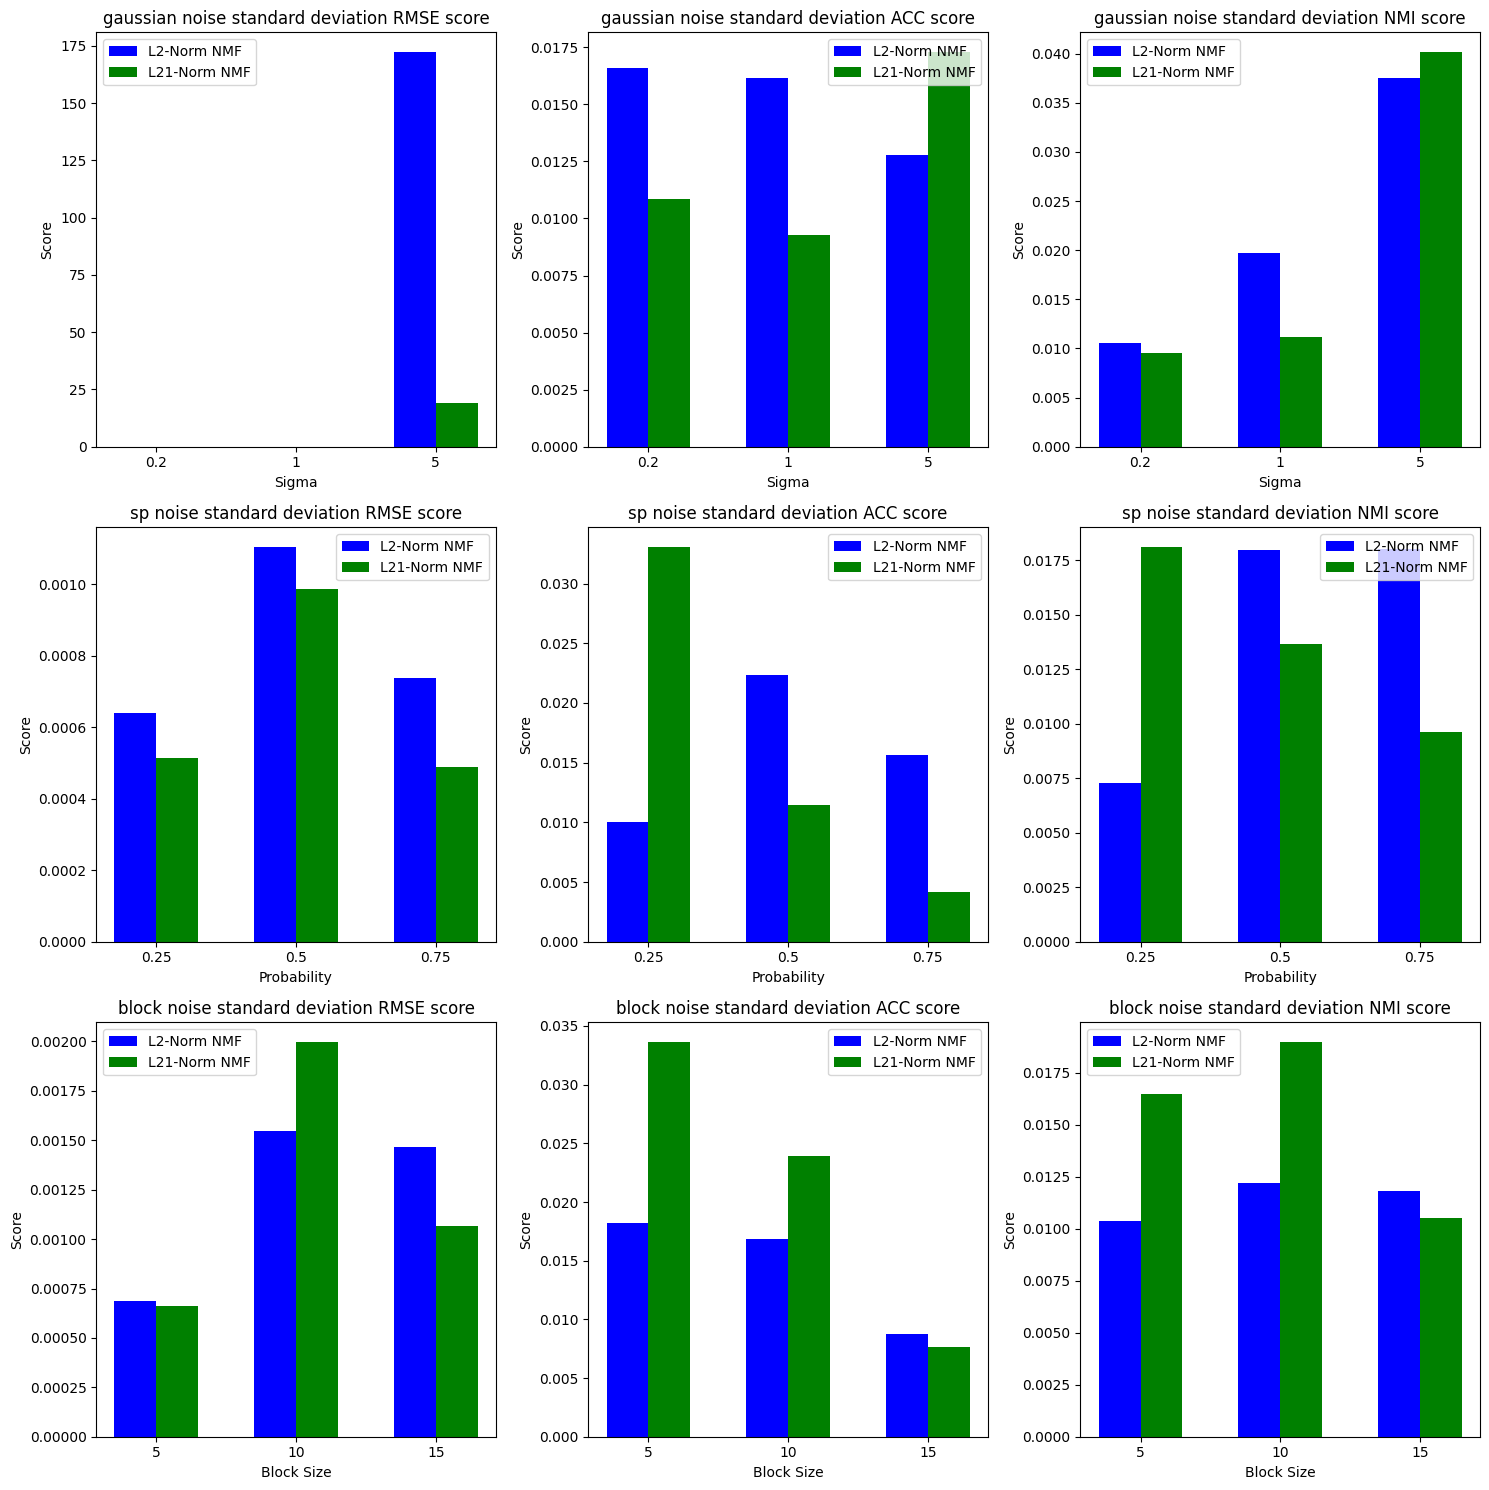

In [ ]:
n_groups = len(noises)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
bar_width = 0.3
index = np.arange(n_groups)
for i, noise_type in enumerate(noises):
  for j, metrics in enumerate(["RMSE","ACC", "NMI"]):
    ax = axs[i][j]
    ax.set_xticks(index + bar_width/2)
    if noise_type == "gaussian":
      ax.set_xticklabels(('0.2', '1', '5'))
      ax.set_xlabel('Sigma')
      if metrics == "RMSE":
        rects1 = ax.bar(index, gaussian_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, gaussian_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, gaussian_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    elif noise_type == "sp":
      ax.set_xticklabels(('0.25', '0.5', '0.75'))
      ax.set_xlabel('Probability')
      if metrics == "RMSE":
        rects1 = ax.bar(index, sp_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, sp_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, sp_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    else:
      ax.set_xticklabels(('5', '10', '15'))
      ax.set_xlabel('Block Size')
      if metrics == "RMSE":
        rects1 = ax.bar(index, block_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, block_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, block_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_nmi_l21, bar_width, color='g', label='L21-Norm NMF')
    ax.set_ylabel('Score')
    ax.set_title(f'{noise_type} noise standard deviation {metrics} score')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

### 5.2. Extended YaleB Dataset

In [ ]:
#Experiments configuration
methods = ["l2", "l21"]
noises = ["gaussian", "sp", "block"]
params = {"gaussian_sigma":[0.2, 1, 5], "sp_p":[0.25, 0.5, 0.75], "block_size": [5, 10, 20]}

#Store data
all_mean_rmse_l2 = []
all_mean_acc_l2 = []
all_mean_nmi_l2 = []
all_stdev_rmse_l2 = []
all_stdev_acc_l2 = []
all_stdev_nmi_l2 = []
all_mean_rmse_l21 = []
all_mean_acc_l21 = []
all_mean_nmi_l21 = []
all_stdev_rmse_l21 = []
all_stdev_acc_l21 = []
all_stdev_nmi_l21 = []

for method in methods:
  for noise in  noises:
    mean_results, stdev_results = experiment(method = method, X = X_yale, Y = Y_yale, noise = noise, **params)
    if method == 'l2':
      for index, value in enumerate(mean_results):
        if index % 3 == 0:
          all_mean_rmse_l2.append(mean_results[index])
          all_stdev_rmse_l2.append(stdev_results[index])
        elif index % 3 == 1:
          all_mean_acc_l2.append(mean_results[index])
          all_stdev_acc_l2.append(stdev_results[index])
        else:
          all_mean_nmi_l2.append(mean_results[index])
          all_stdev_nmi_l2.append(stdev_results[index])
    else:
      for index, value in enumerate(mean_results):
        if index % 3 == 0:
          all_mean_rmse_l21.append(mean_results[index])
          all_stdev_rmse_l21.append(stdev_results[index])
        elif index % 3 == 1:
          all_mean_acc_l21.append(mean_results[index])
          all_stdev_acc_l21.append(stdev_results[index])
        else:
          all_mean_nmi_l21.append(mean_results[index])
          all_stdev_nmi_l21.append(stdev_results[index])

<-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.->
Noise Type: Gaussian
sigma used in this experiment: [0.2, 1, 5]
Method: L2-Norm NMF
-------------------

Experiment Number: 1
number 1 of the parameter
RMSE: 0.10721520175287029, Accuracy: 0.11060480530240265, NMI: 0.14454992673044514
number 2 of the parameter
RMSE: 0.14312805479273918, Accuracy: 0.08823529411764706, NMI: 0.08511168364780783
number 3 of the parameter
RMSE: 2.5599812898717107, Accuracy: 0.04971002485501243, NMI: 0.04959603376297855

Experiment Number: 2
number 1 of the parameter
RMSE: 0.10868262672979824, Accuracy: 0.10770505385252693, NMI: 0.13926781982479872
number 2 of the parameter
RMSE: 0.14419788765842084, Accuracy: 0.09030654515327258, NMI: 0.08171396329608407
number 3 of the parameter
RMSE: 2.8710923199331146, Accuracy: 0.05219552609776305, NMI: 0.05050091667370951

Experiment Number: 3
number 1 of the parameter
RMSE: 0.10728252189389324, Accuracy: 0.1106048

#### Overall Average Result

In [ ]:
gaussian_rmse_l2 = []
sp_rmse_l2 = []
block_rmse_l2 = []
gaussian_acc_l2 = []
sp_acc_l2 = []
block_acc_l2 = []
gaussian_nmi_l2 = []
sp_nmi_l2 = []
block_nmi_l2 = []

gaussian_rmse_l21 = []
sp_rmse_l21 = []
block_rmse_l21 = []
gaussian_acc_l21 = []
sp_acc_l21 = []
block_acc_l21 = []
gaussian_nmi_l21 = []
sp_nmi_l21 = []
block_nmi_l21 = []

for j, value in enumerate(all_stdev_rmse_l2):
  if j < 3:
    gaussian_rmse_l2.append(value)
  elif j < 6:
    sp_rmse_l2.append(value)
  else:
    block_rmse_l2.append(value)

for j, value in enumerate(all_stdev_acc_l2):
  if j < 3:
    gaussian_acc_l2.append(value)
  elif j < 6:
    sp_acc_l2.append(value)
  else:
    block_acc_l2.append(value)

for j, value in enumerate(all_stdev_nmi_l2):
  if j < 3:
    gaussian_nmi_l2.append(value)
  elif j < 6:
    sp_nmi_l2.append(value)
  else:
    block_nmi_l2.append(value)

for j, value in enumerate(all_stdev_rmse_l21):
  if j < 3:
    gaussian_rmse_l21.append(value)
  elif j < 6:
    sp_rmse_l21.append(value)
  else:
    block_rmse_l21.append(value)

for j, value in enumerate(all_stdev_acc_l21):
  if j < 3:
    gaussian_acc_l21.append(value)
  elif j < 6:
    sp_acc_l21.append(value)
  else:
    block_acc_l21.append(value)

for j, value in enumerate(all_stdev_nmi_l21):
  if j < 3:
    gaussian_nmi_l21.append(value)
  elif j < 6:
    sp_nmi_l21.append(value)
  else:
    block_nmi_l21.append(value)

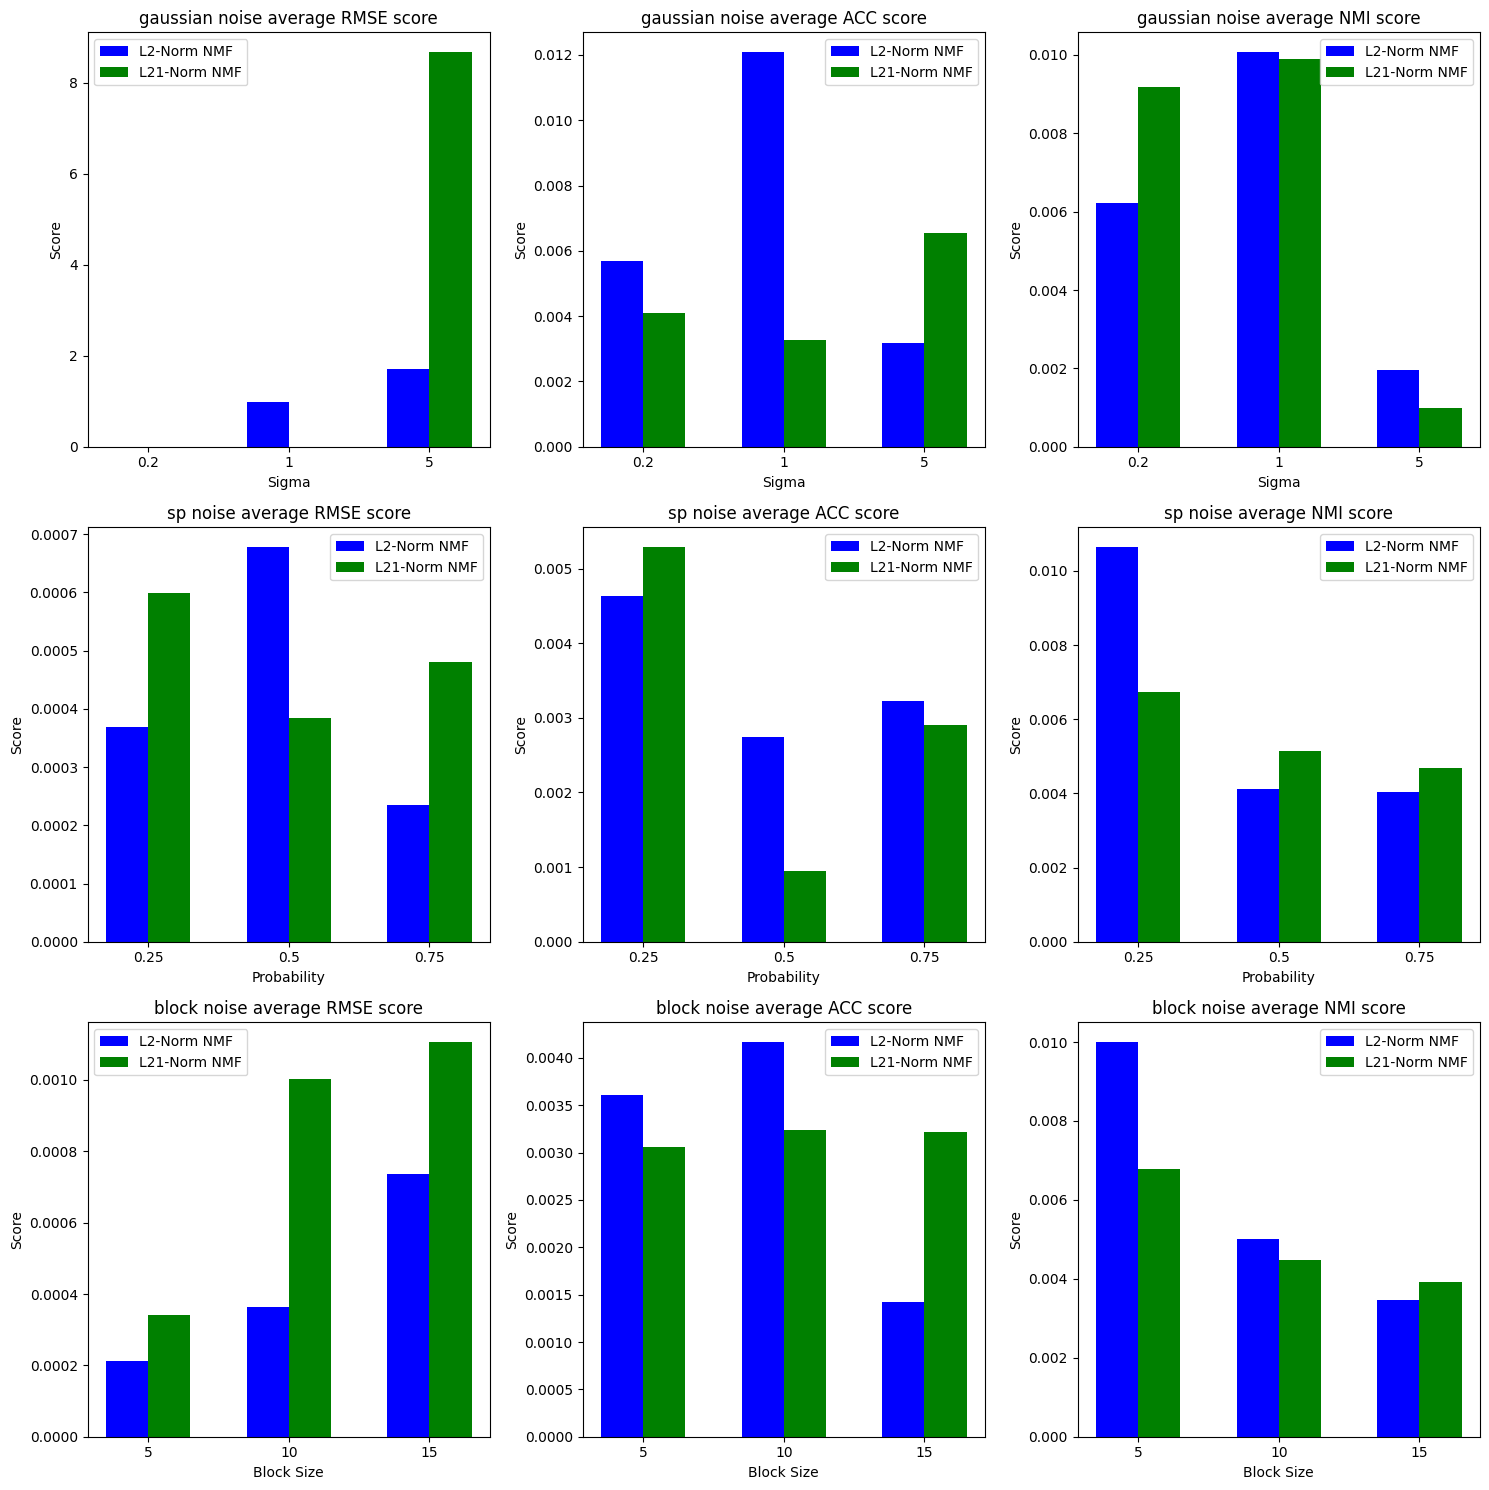

In [ ]:
n_groups = len(noises)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
bar_width = 0.3
index = np.arange(n_groups)
for i, noise_type in enumerate(noises):
  for j, metrics in enumerate(["RMSE","ACC", "NMI"]):
    ax = axs[i][j]
    ax.set_xticks(index + bar_width/2)
    if noise_type == "gaussian":
      ax.set_xticklabels(('0.2', '1', '5'))
      ax.set_xlabel('Sigma')
      if metrics == "RMSE":
        rects1 = ax.bar(index, gaussian_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, gaussian_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, gaussian_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    elif noise_type == "sp":
      ax.set_xticklabels(('0.25', '0.5', '0.75'))
      ax.set_xlabel('Probability')
      if metrics == "RMSE":
        rects1 = ax.bar(index, sp_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, sp_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, sp_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    else:
      ax.set_xticklabels(('5', '10', '15'))
      ax.set_xlabel('Block Size')
      if metrics == "RMSE":
        rects1 = ax.bar(index, block_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, block_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, block_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_nmi_l21, bar_width, color='g', label='L21-Norm NMF')
    ax.set_ylabel('Score')
    ax.set_title(f'{noise_type} noise average {metrics} score')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

#### Overall Standard Deviation Result

In [ ]:
gaussian_rmse_l2 = []
sp_rmse_l2 = []
block_rmse_l2 = []
gaussian_acc_l2 = []
sp_acc_l2 = []
block_acc_l2 = []
gaussian_nmi_l2 = []
sp_nmi_l2 = []
block_nmi_l2 = []

gaussian_rmse_l21 = []
sp_rmse_l21 = []
block_rmse_l21 = []
gaussian_acc_l21 = []
sp_acc_l21 = []
block_acc_l21 = []
gaussian_nmi_l21 = []
sp_nmi_l21 = []
block_nmi_l21 = []

for j, value in enumerate(all_stdev_rmse_l2):
  if j < 3:
    gaussian_rmse_l2.append(value)
  elif j < 6:
    sp_rmse_l2.append(value)
  else:
    block_rmse_l2.append(value)

for j, value in enumerate(all_stdev_acc_l2):
  if j < 3:
    gaussian_acc_l2.append(value)
  elif j < 6:
    sp_acc_l2.append(value)
  else:
    block_acc_l2.append(value)

for j, value in enumerate(all_stdev_nmi_l2):
  if j < 3:
    gaussian_nmi_l2.append(value)
  elif j < 6:
    sp_nmi_l2.append(value)
  else:
    block_nmi_l2.append(value)

for j, value in enumerate(all_stdev_rmse_l21):
  if j < 3:
    gaussian_rmse_l21.append(value)
  elif j < 6:
    sp_rmse_l21.append(value)
  else:
    block_rmse_l21.append(value)

for j, value in enumerate(all_stdev_acc_l21):
  if j < 3:
    gaussian_acc_l21.append(value)
  elif j < 6:
    sp_acc_l21.append(value)
  else:
    block_acc_l21.append(value)

for j, value in enumerate(all_stdev_nmi_l21):
  if j < 3:
    gaussian_nmi_l21.append(value)
  elif j < 6:
    sp_nmi_l21.append(value)
  else:
    block_nmi_l21.append(value)

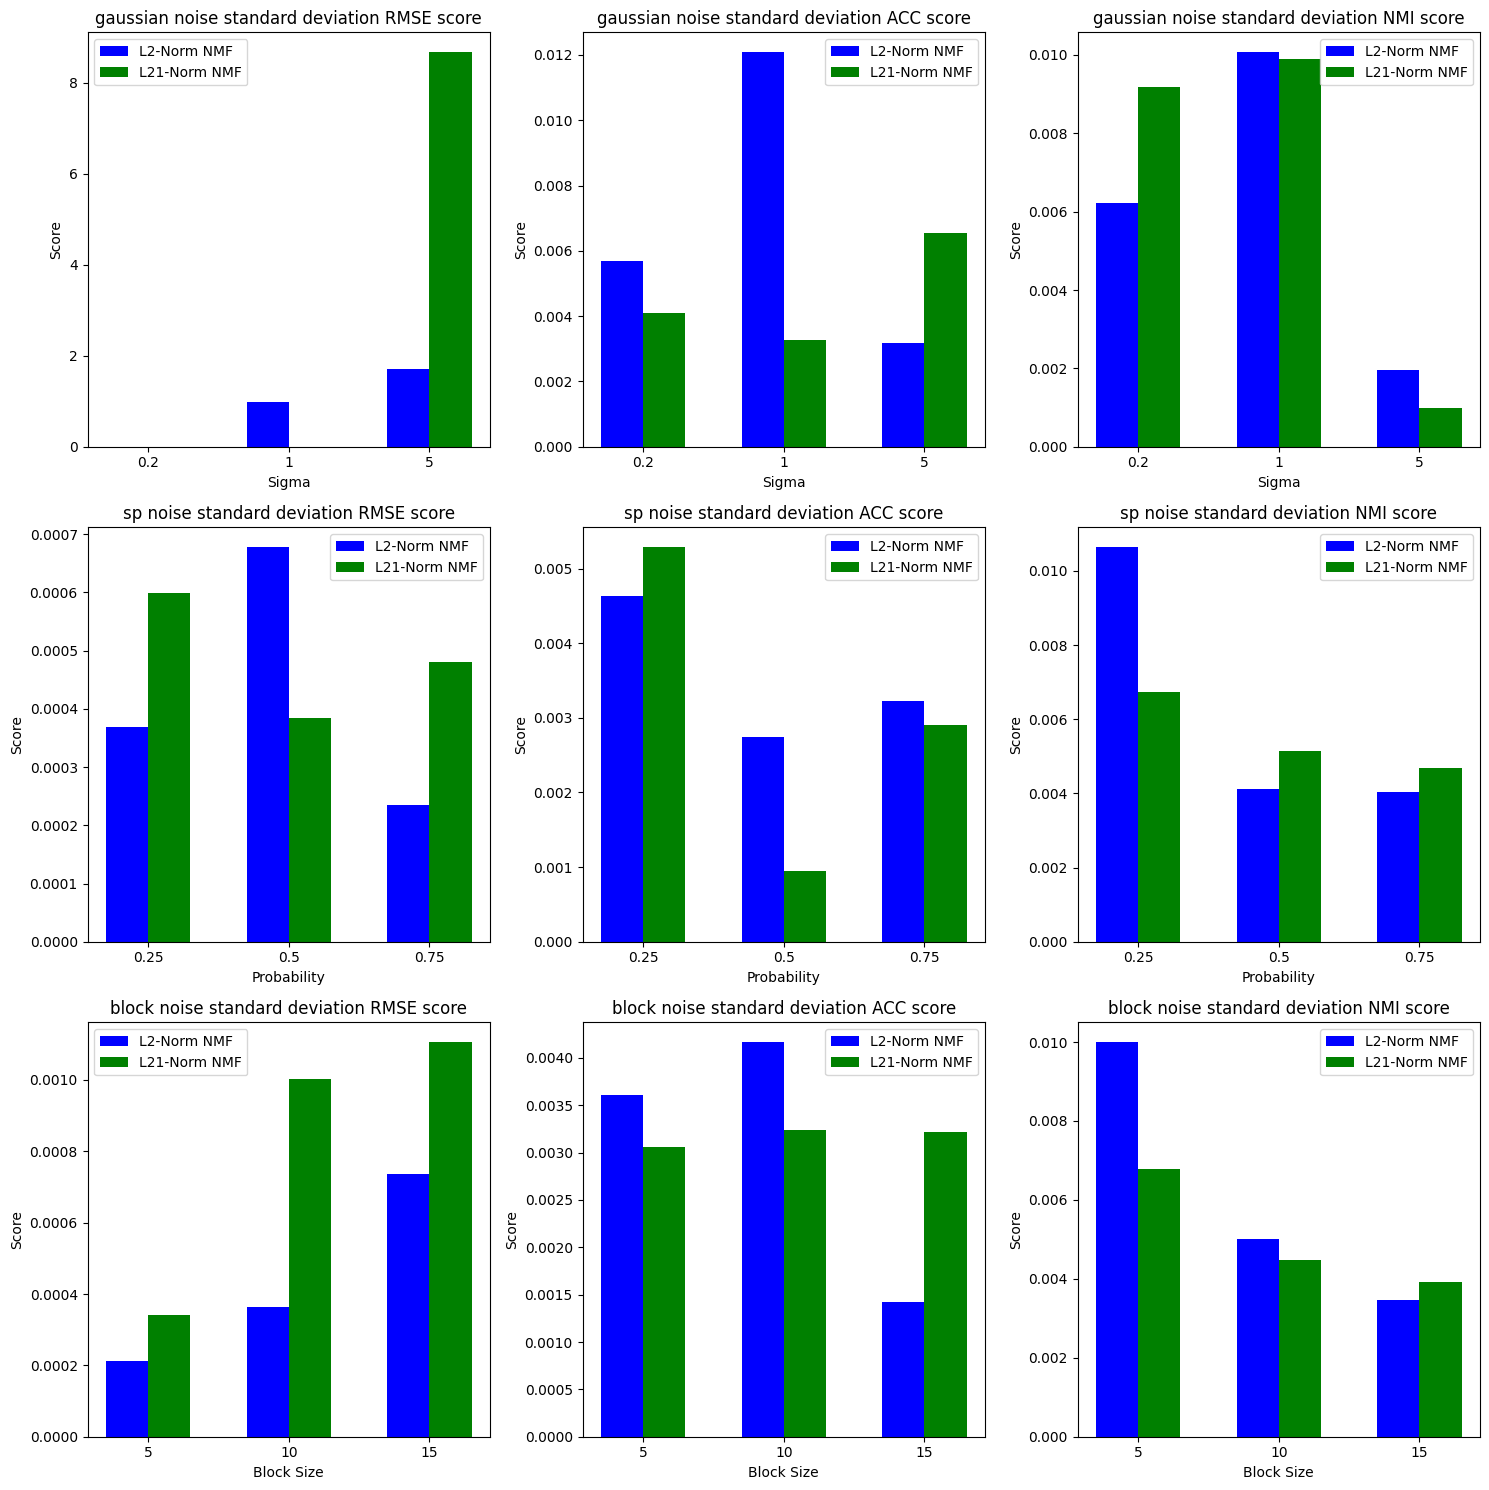

In [ ]:
n_groups = len(noises)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
bar_width = 0.3
index = np.arange(n_groups)
for i, noise_type in enumerate(noises):
  for j, metrics in enumerate(["RMSE","ACC", "NMI"]):
    ax = axs[i][j]
    ax.set_xticks(index + bar_width/2)
    if noise_type == "gaussian":
      ax.set_xticklabels(('0.2', '1', '5'))
      ax.set_xlabel('Sigma')
      if metrics == "RMSE":
        rects1 = ax.bar(index, gaussian_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, gaussian_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, gaussian_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, gaussian_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    elif noise_type == "sp":
      ax.set_xticklabels(('0.25', '0.5', '0.75'))
      ax.set_xlabel('Probability')
      if metrics == "RMSE":
        rects1 = ax.bar(index, sp_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, sp_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, sp_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, sp_nmi_l21, bar_width, color='g', label='L21-Norm NMF')

    else:
      ax.set_xticklabels(('5', '10', '15'))
      ax.set_xlabel('Block Size')
      if metrics == "RMSE":
        rects1 = ax.bar(index, block_rmse_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_rmse_l21, bar_width, color='g', label='L21-Norm NMF')
      elif metrics == "ACC":
        rects1 = ax.bar(index, block_acc_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_acc_l21, bar_width, color='g', label='L21-Norm NMF')
      else:
        rects1 = ax.bar(index, block_nmi_l2, bar_width, color='b', label='L2-Norm NMF')
        rects2 = ax.bar(index + bar_width, block_nmi_l21, bar_width, color='g', label='L21-Norm NMF')
    ax.set_ylabel('Score')
    ax.set_title(f'{noise_type} noise standard deviation {metrics} score')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Appendix

RMSE: 0.12798740575438566
Accuracy: 0.6325
NMI: 0.7864069036152469


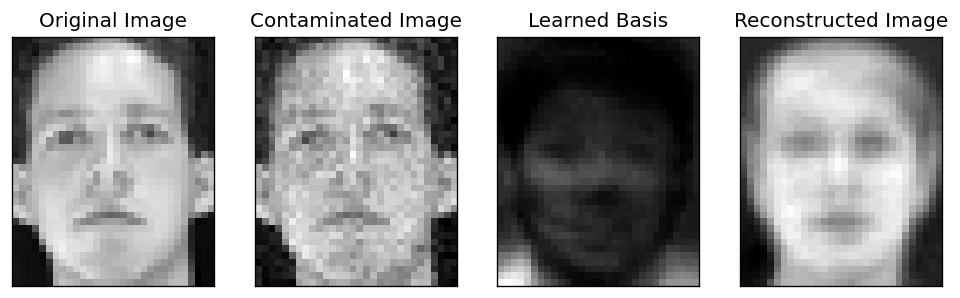

In [ ]:
nmfmodel = l2norm(n_components = 10)
contaminated_X = generate_gaussian_noise(X_ORL, mu = 0, sigma = 0.05)
nmfmodel.fit(X = X_ORL, contaminated_X = contaminated_X, Y = Y_ORL)
U, V = nmfmodel.calculate()
X_hat = nmfmodel.reconstruct_data(U, V)

rmse, acc, nmi = evaluation(X = X_ORL, Y_true = Y_ORL, U = U, V = V)

print(f"RMSE: {rmse}")
print(f"Accuracy: {acc}")
print(f"NMI: {nmi}")

plt.figure(figsize=(10,10), dpi=120)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if i == 0:
      X = X_ORL
      title = "Original Image"
    elif i == 1:
      X = generate_gaussian_noise(X_ORL, mu = 0, sigma = 0.05)
      title = "Contaminated Image"
    elif i == 2:
      X = U
      title = "Learned Basis"
    else:
      X = X_hat
      title = "Reconstructed Image"

    img = convertarray(X[:, 1], h=37, w=30)

    plt.title(f'{title}', fontsize = 12)
    plt.imshow(img, cmap=plt.cm.gray)

plt.show()

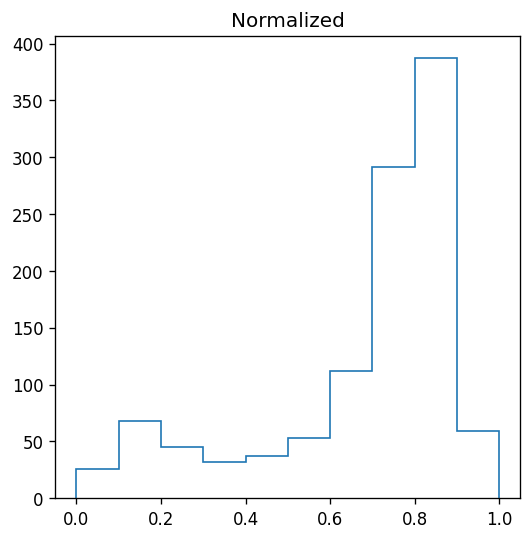

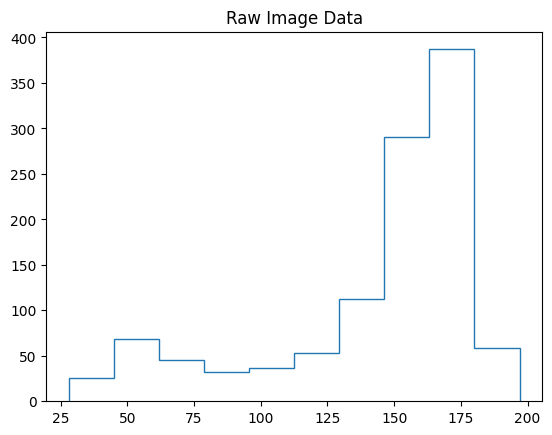

In [ ]:
X_1, Y_1 = load_data(root='drive/MyDrive/data/ORL', reduce = 3, norm = True)
X_2, Y_2 = load_data(root='drive/MyDrive/data/ORL', reduce = 3, norm = False)

hist_num = 2

plt.figure(figsize=(5,5), dpi=120)
x = X_1[:,0]
counts, bins = np.histogram(x)

plt.stairs(counts, bins)
plt.title("Normalized")
plt.show()

y = X_2[:,0]
counts, bins = np.histogram(y)

plt.stairs(counts, bins)
plt.title("Raw Image Data")
plt.show()


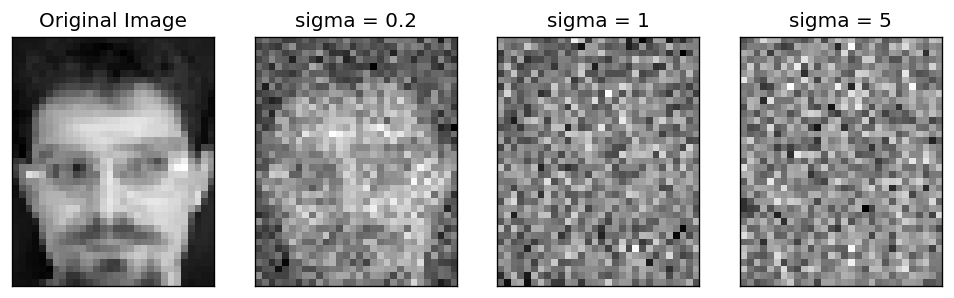

In [ ]:
plt.figure(figsize=(10,10), dpi=120)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if i == 0:
      X_noisy = X_ORL
      title = "Original Image"
    elif i == 1:
      X_noisy = generate_gaussian_noise(X_ORL, sigma = 0.2)
      title = "sigma = 0.2"
    elif i == 2:
      X_noisy = generate_gaussian_noise(X_ORL, sigma = 1)
      title = "sigma = 1"
    else:
      X_noisy = generate_gaussian_noise(X_ORL, sigma = 5)
      title = "sigma = 5"

    noisy_img = convertarray(X_noisy[:, 84], h=37, w=30)

    plt.title(f'{title}', fontsize = 12)
    plt.imshow(noisy_img, cmap=plt.cm.gray)

plt.show()

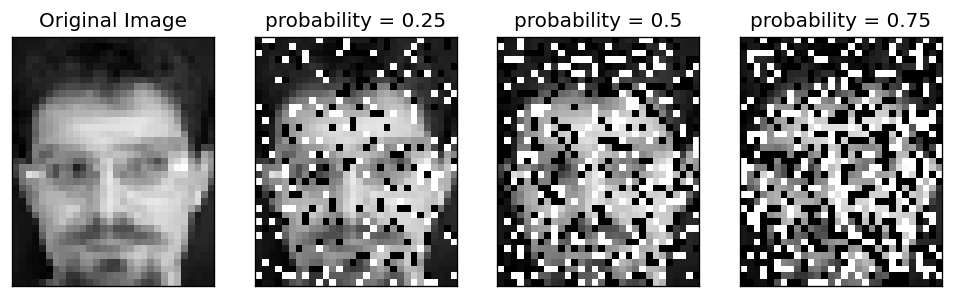

In [ ]:
plt.figure(figsize=(10,10), dpi=120)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if i == 0:
      X_noisy = X_ORL
      title = "Original Image"
    elif i == 1:
      X_noisy = generate_sp_noise(X_ORL, prob = 0.25)
      title = "probability = 0.25"
    elif i == 2:
      X_noisy = generate_sp_noise(X_ORL, prob = 0.5)
      title = "probability = 0.5"
    else:
      X_noisy = generate_sp_noise(X_ORL, prob = 0.75)
      title = "probability = 0.75"

    noisy_img = convertarray(X_noisy[:, 84], h=37, w=30)

    plt.title(f'{title}', fontsize = 12)
    plt.imshow(noisy_img, cmap=plt.cm.gray)

plt.show()

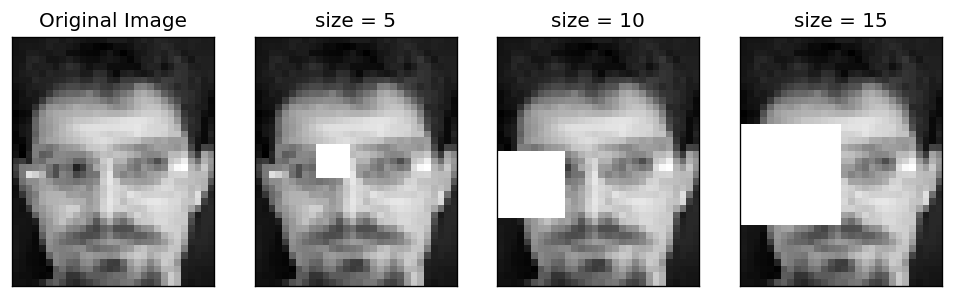

In [ ]:
plt.figure(figsize=(10,10), dpi=120)

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if i == 0:
      X_noisy = X_ORL
      title = "Original Image"
    elif i == 1:
      X_noisy = generate_block_noise(X_ORL, img_w = 30, img_h = 37, size=5)
      title = "size = 5"
    elif i == 2:
      X_noisy = generate_block_noise(X_ORL, img_w = 30, img_h = 37, size=10)
      title = "size = 10"
    else:
      X_noisy = generate_block_noise(X_ORL, img_w = 30, img_h = 37, size=15)
      title = "size = 15"

    noisy_img = convertarray(X_noisy[:, 84], h=37, w=30)

    plt.title(f'{title}', fontsize = 12)
    plt.imshow(noisy_img, cmap=plt.cm.gray)

plt.show()